# Q3

## a

$\hat{P}(Y=1|X=x) = \frac{1}{1+\exp{-<w,x>}}$

## b

In [188]:
import numpy as np

In [189]:
def sigmoid(a,b):
    return 1/(1+np.exp(-np.dot(a,b)))    

In [190]:
# values
w = [0.1,-0.1,0.3]
x0 = [1,1,1,1,1]
x1 = [10,2,15,2,8]
x2 = [2,3,1,1,1]
Y = [0,1,0,0,1]

# calculate
prediction = np.empty(5)
for i in range(5):
    p = sigmoid(w,[x0[i],x1[i],x2[i]])
    prediction[i] = p
    print(p)


0.425557483188341
0.6899744811276125
0.24973989440488245
0.549833997312478
0.401312339887548


## c

In [191]:
import pandas as pd

def true_false_positive_rate(y_true,y_predicted):
    from sklearn.metrics import confusion_matrix
    TN, FP, FN, TP = confusion_matrix(y_true,y_predicted, labels=[0,1]).ravel() 
    return TP/(TP+FN),FP/(FP+TN)

tau = np.arange(0,1.01,0.01)

df = pd.DataFrame(index=np.arange(0,np.size(tau)),
                         columns=['tau','TPR','FPR'])

ind = 0
for t in tau:    
    predict = np.zeros(np.shape(prediction))
    predict[np.argwhere(prediction >= t)] = 1
    TPR,FPR = true_false_positive_rate(Y,predict)
    df.iloc[ind] = [t,TPR,FPR]
    ind+=1

In [192]:
df.drop_duplicates(subset=['TPR','FPR'], keep='first', inplace=True)
df.reset_index(drop=True, inplace = True)

In [193]:
df

,tau,TPR,FPR
0,0,1,1
1,0.25,1,0.666667
2,0.41,0.5,0.666667
3,0.43,0.5,0.333333
4,0.55,0.5,0
5,0.69,0,0


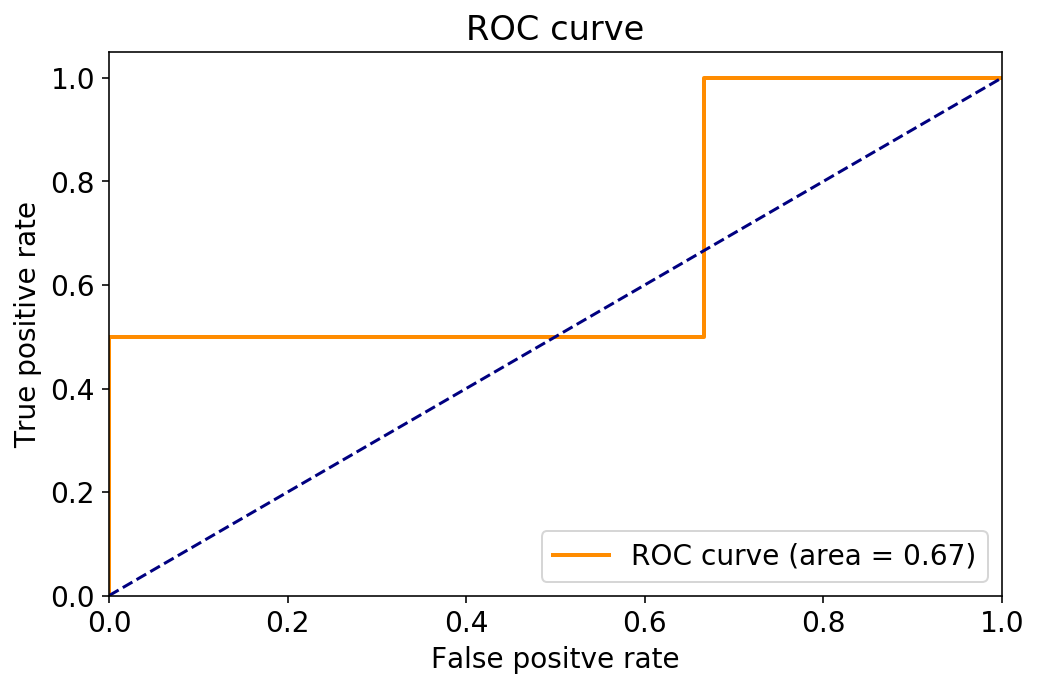

In [194]:
from sklearn import metrics
import matplotlib.pyplot as plt
# plot the results 
%config InlineBackend.figure_format = 'retina'

auc = metrics.roc_auc_score(Y, prediction)

plt.figure()
plt.plot(df['FPR'],df['TPR'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positve rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

# set parameters
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 14
plt.show();

# Q4

## a

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

In [196]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=98, test_size=0.3)

In [197]:
def adjust_labels_to_binary(y_train, target_class_value):
    y_train_adj = np.copy(y_train)
    y_train_adj[y_train != target_class_value] = -1
    y_train_adj[y_train == target_class_value] = 1
    return y_train_adj

## b

In [198]:
def one_vs_rest(x_train, y_train, target_class_value):
    y_train_binarized = adjust_labels_to_binary(y_train, target_class_value)
    clf = LogisticRegression(fit_intercept=True).fit(x_train,y_train_binarized)
    return clf

## c

In [199]:
def binarized_confusion_matrix(X, y_binarized, one_vs_rest_model, prob_threshold):
    from sklearn.metrics import confusion_matrix
    y_predicted_probabilities = one_vs_rest_model.predict_proba(X)[:,1] #class 1
    ind = y_predicted_probabilities>=prob_threshold
    y_predicted = -1*np.ones(np.shape(y_binarized))
    y_predicted[ind] = 1
    TN, FP, FN, TP = confusion_matrix(y_binarized,y_predicted, labels=[-1,1]).ravel() 
    # reorder the confusion matrix to display as asked 
    return TP,FN,FP,TN


## d

In [200]:
target = [0,1,2]
threshold = 0.5

display('[TP, FN]',
        '[FP, TN]')

# train
for t in target:
    y_binarized = adjust_labels_to_binary(y_train, target_class_value=t)
    one_vs_rest_model = one_vs_rest(X_train, y_train, target_class_value=t)
    print('train data, target class {}'.format(t))
    TP,FN,FP,TN = binarized_confusion_matrix(X_train,y_binarized, one_vs_rest_model, threshold)
    cm = [[TP, FN],[FP, TN]]
    print(np.matrix(cm))
    print('\n')

# test
for t in target:
    y_binarized = adjust_labels_to_binary(y_test, target_class_value=t)
    one_vs_rest_model = one_vs_rest(X_train, y_train, target_class_value=t)
    print('test data, target class {}'.format(t))
    TP,FN,FP,TN = binarized_confusion_matrix(X_test,y_binarized, one_vs_rest_model, threshold)
    cm = [[TP, FN],[FP, TN]]
    print(np.matrix(cm))
    print('\n')  

'[TP, FN]'

'[FP, TN]'

train data, target class 0
[[39  0]
 [ 0 66]]


train data, target class 1
[[ 2 29]
 [ 8 66]]


train data, target class 2
[[35  0]
 [ 1 69]]


test data, target class 0
[[11  0]
 [ 0 34]]


test data, target class 1
[[ 3 16]
 [ 1 25]]


test data, target class 2
[[15  0]
 [ 3 27]]




## e

In [201]:
def micro_avg_precision(X, y, all_target_class_dict, prob_threshold):
    target = [0,1,2]
    total_TP = []
    total_FP = []
    for t in target:        
        y_binarized = adjust_labels_to_binary(y, target_class_value=t)
        one_vs_rest_model = all_target_class_dict[np.str(t)]   
        TP,FN,FP,TN = binarized_confusion_matrix(X,y_binarized, one_vs_rest_model, prob_threshold)
        total_TP.append(TP)
        total_FP.append(FP)
    MAP = np.sum(total_TP)/(np.sum(total_TP) + np.sum(total_FP))
    return MAP

In [202]:
# test it
prob_threshold = 0.5
all_target_class_dict = {'0':one_vs_rest(X_train, y_train, target_class_value=0),'1':one_vs_rest(X_train, y_train, target_class_value=1),'2':one_vs_rest(X_train, y_train, target_class_value=2)}
display(micro_avg_precision(X_train, y_train, all_target_class_dict, prob_threshold))


0.8941176470588236

## f

In [203]:
def micro_avg_recall(X, y, all_target_class_dict, prob_threshold):
    target = [0,1,2]
    total_TP = []
    total_FN = []
    for t in target:        
        y_binarized = adjust_labels_to_binary(y, target_class_value=t)
        one_vs_rest_model = all_target_class_dict[np.str(t)]   
        TP,FN,FP,TN = binarized_confusion_matrix(X,y_binarized, one_vs_rest_model, prob_threshold)
        total_TP.append(TP)
        total_FN.append(FN)
    MAR = np.sum(total_TP)/(np.sum(total_TP) + np.sum(total_FN))
    return MAR

In [204]:
# test it
prob_threshold = 0.5
all_target_class_dict = {'0':one_vs_rest(X_train, y_train, target_class_value=0),'1':one_vs_rest(X_train, y_train, target_class_value=1),'2':one_vs_rest(X_train, y_train, target_class_value=2)}
display(micro_avg_recall(X_train, y_train, all_target_class_dict, prob_threshold))

0.7238095238095238

## g

In [205]:
def micro_avg_false_positve_rate(X, y, all_target_class_dict, prob_threshold):
    target = [0,1,2]
    total_TN = []
    total_FP = []
    for t in target:        
        y_binarized = adjust_labels_to_binary(y, target_class_value=t)
        one_vs_rest_model = all_target_class_dict[np.str(t)]   
        TP,FN,FP,TN = binarized_confusion_matrix(X,y_binarized, one_vs_rest_model, prob_threshold)
        total_TN.append(TN)
        total_FP.append(FP)
    MAFPR = np.sum(total_FP)/(np.sum(total_TN) + np.sum(total_FP))
    return MAFPR

In [206]:
# test it
prob_threshold = 0.5
all_target_class_dict = {'0':one_vs_rest(X_train, y_train, target_class_value=0),'1':one_vs_rest(X_train, y_train, target_class_value=1),'2':one_vs_rest(X_train, y_train, target_class_value=2)}
display(micro_avg_false_positve_rate(X_train, y_train, all_target_class_dict, prob_threshold))

0.04285714285714286

## h

In [207]:
Tau = np.arange(0.3,0.8,0.05) 
all_target_class_dict = {'0':one_vs_rest(X_train, y_train, target_class_value=0),'1':one_vs_rest(X_train, y_train, target_class_value=1),'2':one_vs_rest(X_train, y_train, target_class_value=2)}

ROC = pd.DataFrame(index=np.arange(0,np.size(Tau)),
                         columns=['tau','MAR','MAFPR'])
ind = 0
for tau in Tau:
    MAR = micro_avg_recall(X_train, y_train, all_target_class_dict, tau)
    MAFPR = micro_avg_false_positve_rate(X_train, y_train, all_target_class_dict, tau)
    ROC.iloc[ind] = [tau,MAR,MAFPR]
    ind+=1

In [208]:
ROC

,tau,MAR,MAFPR
0,0.3,0.942857,0.128571
1,0.35,0.904762,0.0952381
2,0.4,0.847619,0.0666667
3,0.45,0.780952,0.047619
4,0.5,0.72381,0.0428571
5,0.55,0.72381,0.0333333
6,0.6,0.714286,0.0238095
7,0.65,0.657143,0.0047619
8,0.7,0.647619,0.0047619
9,0.75,0.628571,0.0047619


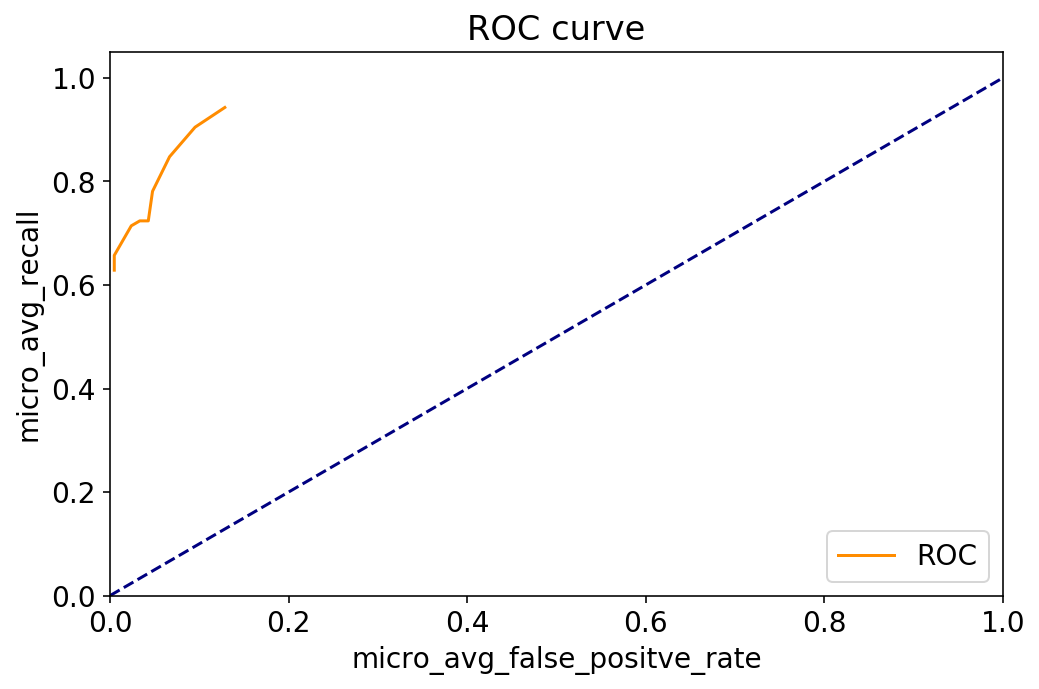

In [209]:
from sklearn import metrics
import matplotlib.pyplot as plt
# plot the results 
%config InlineBackend.figure_format = 'retina'

plt.figure()
plt.plot(ROC['MAFPR'], ROC['MAR'], color='darkorange',
         label='ROC')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('micro_avg_false_positve_rate')
plt.ylabel('micro_avg_recall')
plt.title('ROC curve')
plt.legend(loc="lower right")

# set parameters
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 14
plt.show();

## i

In [210]:
def f_beta(precision, recall, beta):
    fBeta = (1+beta**2)*(precision*recall)/(precision*beta**2 + recall)
    return fBeta

## j

In [211]:
beta = np.arange(0,10.5,0.5)
all_target_class_dict = {'0':one_vs_rest(X_train, y_train, target_class_value=0),'1':one_vs_rest(X_train, y_train, target_class_value=1),'2':one_vs_rest(X_train, y_train, target_class_value=2)}
fb03 = []
fb05 = []
fb07 = []
for b in beta:
    recall = micro_avg_recall(X_train, y_train, all_target_class_dict, 0.3)    
    precision = micro_avg_precision(X_train, y_train, all_target_class_dict, 0.3)
    fb03.append(f_beta(precision, recall, b))
    recall = micro_avg_recall(X_train, y_train, all_target_class_dict, 0.5)    
    precision = micro_avg_precision(X_train, y_train, all_target_class_dict, 0.5)
    fb05.append(f_beta(precision, recall, b))
    recall = micro_avg_recall(X_train, y_train, all_target_class_dict, 0.7)    
    precision = micro_avg_precision(X_train, y_train, all_target_class_dict, 0.7)
    fb07.append(f_beta(precision, recall, b))

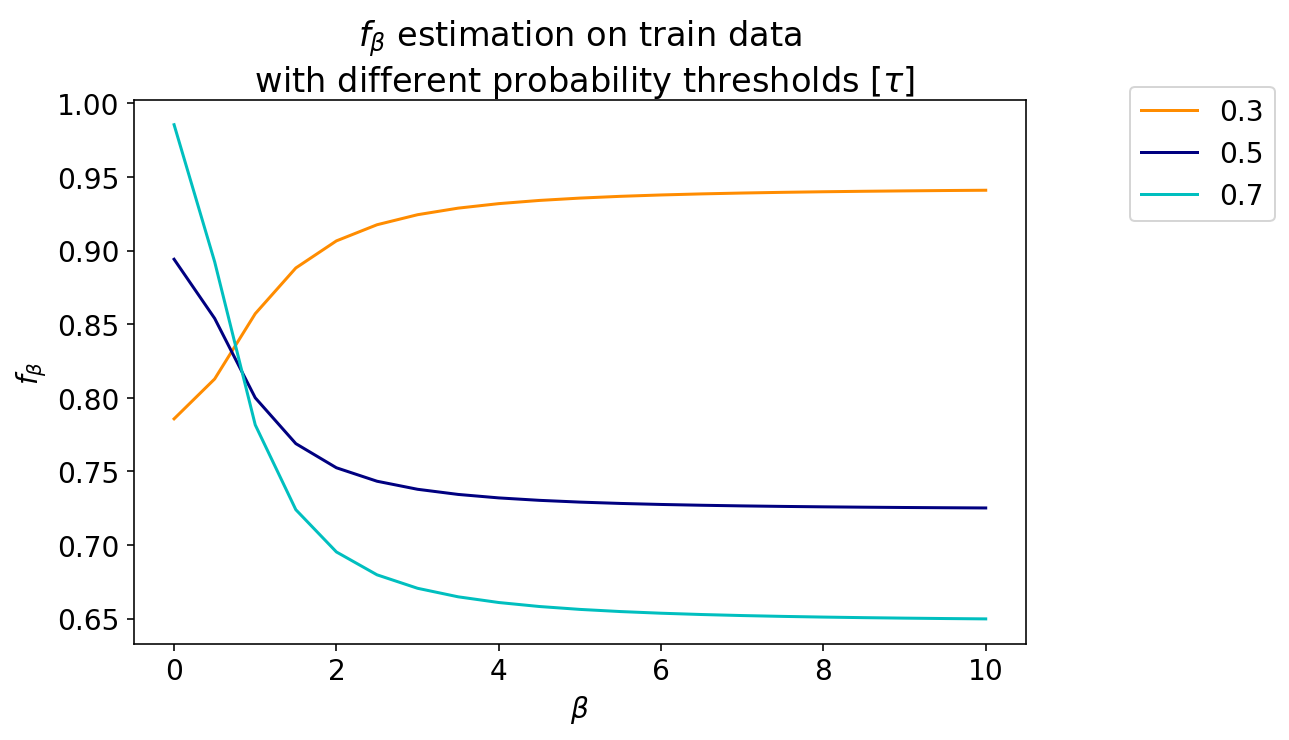

In [212]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
plt.plot(beta,fb03,color='darkorange',label='0.3')
plt.plot(beta,fb05,color='navy',label='0.5')
plt.plot(beta,fb07,color='c',label='0.7')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$f_\beta$')
plt.title(r'$f_\beta$'+ ' estimation on train data\n with different probability thresholds ' + r'$[\tau]$')
plt.legend(loc="center right",title='probability threshold')
ax.legend(bbox_to_anchor=(1.1, 1.05))

# set parameters
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 14
plt.show();